In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer

warnings.filterwarnings("ignore")


In [3]:
train_cv = pd.read_csv('train_adc/train.csv')
items = pd.read_csv('train_adc/item_data.csv')
view_logs = pd.read_csv('train_adc/view_log.csv')

print(train_cv.columns.tolist(),items.columns.tolist(),view_logs.columns.tolist())

['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version', 'is_4G', 'is_click'] ['item_id', 'item_price', 'category_1', 'category_2', 'category_3', 'product_type'] ['server_time', 'device_type', 'session_id', 'user_id', 'item_id']


In [4]:
# Check data types and missing values
for name, df in zip(['Train', 'Items', 'View Logs'], [train_cv, items, view_logs]):
    # print(f"\n{name} Info:")
    # display(df.info())
    print(f"\n{name} Nulls:\n{df.isnull().sum()}")


Train Nulls:
impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64

Items Nulls:
item_id         0
item_price      0
category_1      0
category_2      0
category_3      0
product_type    0
dtype: int64

View Logs Nulls:
server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64


In [5]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import shapiro, normaltest, probplot

# # Example: df is your DataFrame
# cols = ['avg_item_price', 'max_item_price']

# for col in cols:
#     print(f"\n--- Checking Normality for: {col} ---")
    
#     # Histogram
#     sns.histplot(train_cv[col].dropna(), kde=True)
#     plt.title(f"Histogram of {col}")
#     plt.show()
    
#     # Q-Q Plot
#     probplot(df[col].dropna(), dist="norm", plot=plt)
#     plt.title(f"Q-Q Plot of {col}")
#     plt.show()
    
#     # Shapiro-Wilk test (good for small samples)
#     stat, p = shapiro(df[col].dropna())
#     print(f"Shapiro-Wilk Test → Statistic={stat:.3f}, p={p:.3f}")
    
#     # D’Agostino and Pearson’s test (good for larger samples)
#     stat, p = normaltest(df[col].dropna())
#     print(f"D’Agostino Test → Statistic={stat:.3f}, p={p:.3f}")
    
#     if p > 0.05:
#         print(f"{col} looks **normal** (fail to reject H0).")
#     else:
#         print(f"{col} is **not normal** (reject H0).")


In [6]:
# df['avg_item_price'].fillna(df['avg_item_price'].median(), inplace=True)
# df['max_item_price'].fillna(df['max_item_price'].median(), inplace=True)
# df.drop(columns=["item_price", "category_1", "category_2", "category_3", "product_type"], inplace=True)


In [7]:
train_cv['impression_time'] = pd.to_datetime(train_cv['impression_time'])
view_logs['server_time'] = pd.to_datetime(view_logs['server_time'])

In [8]:
# Merge view_logs with item data to enrich view log information
view_logs = view_logs.merge(items, on='item_id', how='left')


In [9]:
# Create user-level aggregated features from view logs without NaNs
user_view_agg = (
    view_logs.groupby('user_id', dropna=False)
    .agg({
        'item_id': lambda x: x.count(),  # count non-NaN
        'item_price': [
            lambda x: x.mean(skipna=True),
            lambda x: x.max(skipna=True)
        ],
        'category_1': lambda x: x.nunique(dropna=True),
        'category_2': lambda x: x.nunique(dropna=True),
        'category_3': lambda x: x.nunique(dropna=True),
        'product_type': lambda x: x.nunique(dropna=True),
    })
    .reset_index()
)

# Rename columns
user_view_agg.columns = [
    'user_id', 
    'total_views', 
    'avg_item_price', 
    'max_item_price',
    'unique_cat1', 
    'unique_cat2', 
    'unique_cat3', 
    'unique_product_types'
]

# Replace any remaining NaNs with 0 (e.g., for users with no price info)
user_view_agg = user_view_agg.fillna(0)


In [10]:
train_cv = train_cv.merge(user_view_agg, on='user_id', how='left')

In [11]:
train_cv = train_cv.merge(view_logs[['user_id', 'device_type']], on='user_id', how='left')

In [12]:
train_cv.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'total_views', 'avg_item_price', 'max_item_price',
       'unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types',
       'device_type'],
      dtype='object')

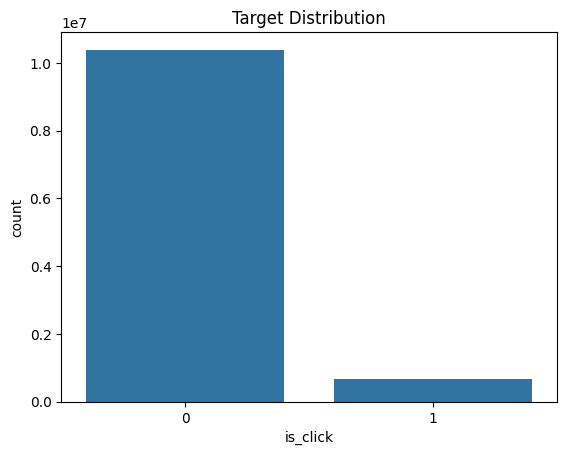

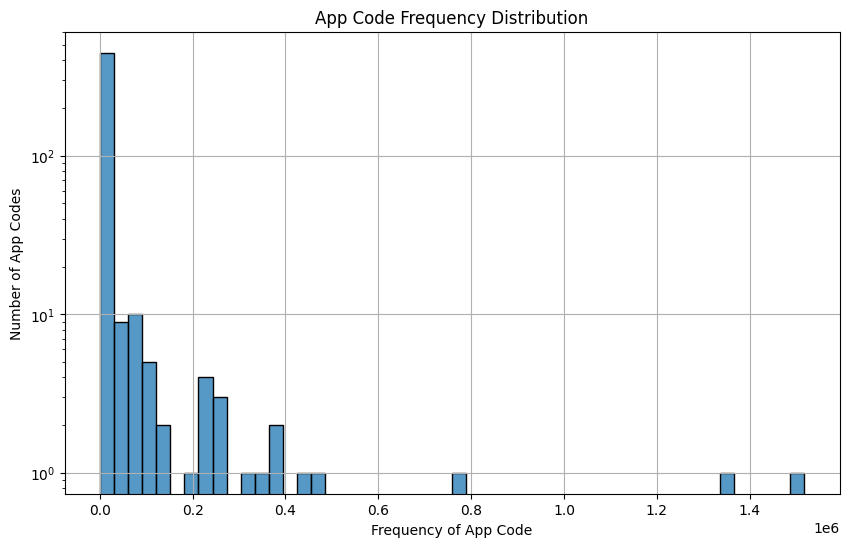

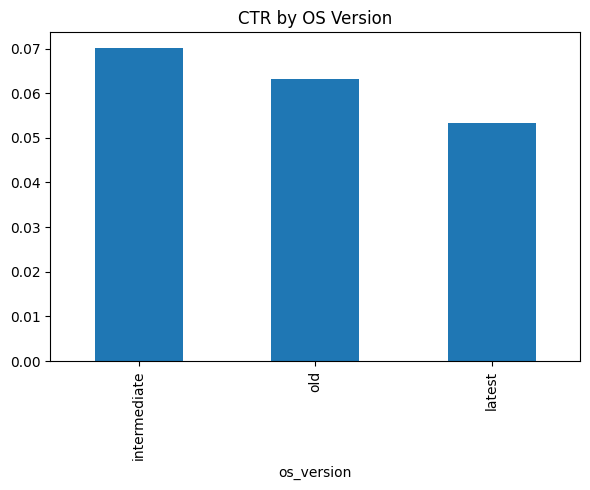

In [13]:
sns.countplot(data=train_cv, x='is_click')
plt.title('Target Distribution')

app_code_counts = train_cv['app_code'].value_counts()

# Plot the frequencies (log scale helps if highly skewed)
plt.figure(figsize=(10, 6))
sns.histplot(app_code_counts, bins=50, kde=False)
plt.title('App Code Frequency Distribution')
plt.xlabel('Frequency of App Code')
plt.ylabel('Number of App Codes')
plt.yscale('log')  # Optional: Log scale helps if data is very skewed
plt.grid(True)
plt.show()

# CTR by OS Version
plt.figure(figsize=(6, 5))
train_cv.groupby('os_version')['is_click'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('CTR by OS Version')
plt.tight_layout()

plt.show()

In [14]:
train_cv['impression_time'] = pd.to_datetime(train_cv['impression_time'])

train_cv['hour'] = train_cv['impression_time'].dt.hour
train_cv['dayofweek'] = train_cv['impression_time'].dt.dayofweek
train_cv['is_weekend'] = train_cv['dayofweek'].isin([5, 6]).astype(int)

In [15]:
cols_to_encode = ["os_version", "device_type"]

for col in cols_to_encode:
    mask = train_cv[col].apply(lambda x: isinstance(x, (list, tuple, np.ndarray)))
    if mask.any():
        print(f"Column '{col}' has array-like values at indices: {train_cv.index[mask].tolist()}")
        print(train_cv.loc[mask, col])

In [16]:
train_cv = train_cv.drop(index=224520)

In [17]:
le = LabelEncoder()
ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' for dummy trap, sparse_output=False for DataFrame

for col in ['unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types']:
    train_cv[col] = train_cv[col].astype(str)  # If needed
    train_cv[col] = le.fit_transform(train_cv[col])
encoded_array = ohe.fit_transform(train_cv[cols_to_encode])
encoded_df = pd.DataFrame(
    encoded_array, 
    columns=ohe.get_feature_names_out(cols_to_encode),
    index=train_cv.index
)
train_cv = pd.concat([train_cv.drop(columns=cols_to_encode), encoded_df], axis=1)


In [18]:
app_click_rate = train_cv.groupby('app_code')['is_click'].mean()
train_cv['app_code_click_rate'] = train_cv['app_code'].map(app_click_rate)

In [19]:
# Frequency of each app_code
app_freq = train_cv['app_code'].value_counts()

# Click rate per app_code
app_click_rate = train_cv.groupby('app_code')['is_click'].mean()

# Combine into one DataFrame
app_stats = pd.DataFrame({
    'frequency': app_freq,
    'click_rate': app_click_rate
})

# Mark rare
thresholds = [10,20,30,40,50]  # try 10, 30, 50, etc.
for threshold in thresholds:
    app_stats['is_rare'] = app_stats['frequency'] < threshold

    # Compare variance
    print("At Threshold ->",threshold)
    print("Click rate variance for frequent apps:", app_stats.loc[~app_stats['is_rare'], 'click_rate'].var())
    print("Click rate variance for rare apps:", app_stats.loc[app_stats['is_rare'], 'click_rate'].var())

    # Plot click rate vs frequency
    # import matplotlib.pyplot as plt
    # plt.figure(figsize=(8,5))
    # plt.scatter(app_stats['frequency'], app_stats['click_rate'], alpha=0.5)
    # plt.xscale('log')
    # plt.xlabel('Frequency (log scale)')
    # plt.ylabel('Click Rate')
    # plt.title('Click Rate vs App Code Frequency')
    # plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    # plt.legend()
    # plt.show()


At Threshold -> 10
Click rate variance for frequent apps: 0.028218142997270244
Click rate variance for rare apps: 0.044397463002114175
At Threshold -> 20
Click rate variance for frequent apps: 0.025516718174889326
Click rate variance for rare apps: 0.055413469735720394
At Threshold -> 30
Click rate variance for frequent apps: 0.02201618081368292
Click rate variance for rare apps: 0.06859056193867727
At Threshold -> 40
Click rate variance for frequent apps: 0.022200945737065207
Click rate variance for rare apps: 0.06007926268402907
At Threshold -> 50
Click rate variance for frequent apps: 0.020995560294643712
Click rate variance for rare apps: 0.06124083877710139


In [20]:
threshold = 40

# Count frequencies
app_freq = train_cv['app_code'].value_counts()

# Identify rare ones
rare_apps = app_freq[app_freq < threshold].index

# Create cleaned column
train_cv['app_code_cleaned'] = train_cv['app_code'].apply(lambda x: 'other' if x in rare_apps else x)

In [21]:
# Click rate after grouping
app_click_rate = train_cv.groupby('app_code_cleaned')['is_click'].mean()

# Map back to dataset
train_cv['app_code_click_rate'] = train_cv['app_code_cleaned'].map(app_click_rate)


In [22]:
train_cv.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'is_4G',
       'is_click', 'total_views', 'avg_item_price', 'max_item_price',
       'unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types',
       'hour', 'dayofweek', 'is_weekend', 'os_version_latest',
       'os_version_old', 'device_type_iphone', 'device_type_web',
       'app_code_click_rate', 'app_code_cleaned'],
      dtype='object')

In [23]:
features = [
    'app_code', 'os_version_latest','os_version_old','is_4G',
    'hour', 'dayofweek', 'is_weekend',
    'device_type_iphone', 'device_type_web',
    'total_views', 'avg_item_price', 'max_item_price',
    'unique_cat1', 'unique_cat2', 'unique_cat3', 'unique_product_types'
]
target = 'is_click'

In [24]:
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# poly_features = poly.fit_transform(train_cv[features])  # Replace X with your feature matrix
# poly_feature_names = poly.get_feature_names_out(train_cv[features].columns)
# X_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=train_cv[features].index)

# print(f"✅ Added {X_poly.shape[1] - X.shape[1]} polynomial & interaction features.")

In [ ]:
# from sklearn.feature_selection import SelectKBest, mutual_info_classif

# # 5️⃣ Feature Selection with Mutual Information
# # Select top k features (max 30 or total available)
# mi_selector = SelectKBest(mutual_info_classif, k=min(10, train_cv[features].shape[1]))

# # Fit selector on X, y
# X_selected = mi_selector.fit_transform(train_cv[features], train_cv[target])

# # Get the names of selected features
# selected_feature_names = train_cv[features].columns[mi_selector.get_support()]

# # Replace X with selected features
# X = pd.DataFrame(X_selected, columns=selected_feature_names, index=train_cv[features].index)

# print(f"✅ Selected top {X.shape[1]} features using Mutual Information: {list(selected_feature_names)}")

In [ ]:
import pandas as pd

# Example: df is your dataset
# df = pd.read_csv("your_file.csv")

# Separate majority and minority classes
majority_class = train_cv[train_cv[target] == 0]
minority_class = train_cv[train_cv[target] == 1]

# Undersample majority class to match minority count
majority_class_undersampled = majority_class.sample(
    n=len(minority_class),
    random_state=42
)

# Combine minority class with undersampled majority class
df_balanced = pd.concat([minority_class, majority_class_undersampled])

# Shuffle the resulting dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Before undersampling:", train_cv[target].value_counts())
print("After undersampling:", df_balanced[target].value_counts())

# Now df_balanced can be used for training


Before undersampling: is_click
0    10391260
1      661621
Name: count, dtype: int64
After undersampling: is_click
0    661621
1    661621
Name: count, dtype: int64


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75    132411
           1       0.75      0.77      0.76    132238

    accuracy                           0.76    264649
   macro avg       0.76      0.76      0.76    264649
weighted avg       0.76      0.76      0.76    264649

ROC-AUC Score: 0.8412026867805595
Confusion Matrix:
 [[ 98453  33958]
 [ 30798 101440]]


<Axes: >

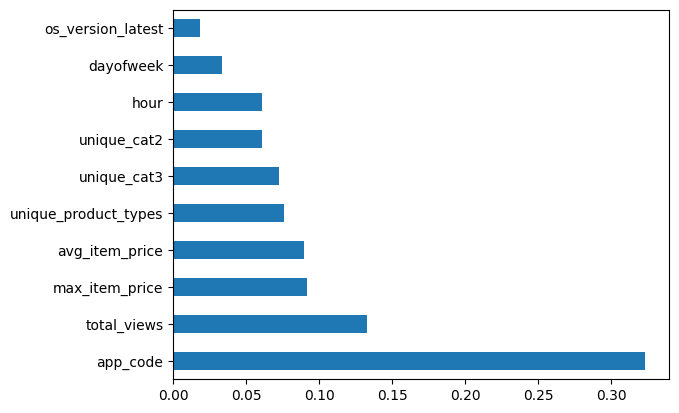

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

# 1. Train-test split
X = df_balanced[features]  # Replace 'target' with your target column name
y = df_balanced[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Baseline Model
model = RandomForestClassifier( random_state=42,
    n_estimators=50,       # fewer trees
    max_depth=10,          # limit depth
    n_jobs=-1 ,
    class_weight='balanced'
    )
model.fit(X_train, y_train)

# 3. Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 4. Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 5. Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')